# Beam Shape Analysis - Cleaved Fibre

### What does this notebook do?

Experimental analysis
- Import Gaussian beamshape data and z values through pandas to np arrays
- Translate and transform Gaussians to reduce fitting parameters 
- Fit the beamshape Gaussians to a one parameter fit to find their waists, w
- multiply z by sin(theta), where theta is the elevation angle of the setup - so that we resolve the projection onto the camera image
- Plot ws vs zsin(theta) and fit to (Two/ three parameter?) Fit
- Key: what is z0 and w0 experimentally for the fibre?

Theoretical Analysis
- Takes in wavelength, NA, core radius to calculate V number
- Use marcuse relation to find minumum waist
- Comparison?

In [44]:
''' IMPORTANT: compared to annotated picture, 11th data point was deleted due to corrupted file. File was called '1007'. Therefore now working with 16 data points'''

" IMPORTANT: compared to annotated picture, 11th data point was deleted due to corrupted file. File was called '1007'. Therefore now working with 16 data points"

## Import all useful libraries / tools

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from os import listdir
import scipy

## Import Data

Function below that takes path and returns distances and amplitudes from all csv files in that folder, as np.ndarrays in a big list

In [23]:
def import_data(global_path):

    # Function which finds filenames of csvs in a folder
    def find_csv_filenames( path_to_dir, suffix=".csv" ):
        filenames = listdir(path_to_dir)
        return [ filename for filename in filenames if filename.endswith( suffix ) ]
    
    def sort_int(examp):
        pos = 1
        while examp[:pos].isdigit():
            pos += 1
        return examp[:pos-1] if pos > 1 else examp

    # the list of files in the folder
    files_list = find_csv_filenames(global_path)
    
    sorted(files_list, key=sort_int) # sort files

    files_list = files_list[:-1] # -1 to not include 'zs' csv file - import this later

    # empty lists to put values in
    distances = []
    amps = []

    print(files_list)

    # loop through file names in directory
    for f in range(len(files_list)):

        # Import an execl sheet as dataframe, called 'Values1'
        # NB: Image J seems to have saved this 'excel sheet' as a csv file
        df_test = pd.read_csv(global_path + files_list[f])

        # Extracing a column by title and converting data to array
        distances.append(np.array(df_test['Distance_(microns)']))
        amps.append(np.array(df_test['Gray_Value']))

    # returning arrays within two big lists
    return distances, amps

In [24]:
# Define useful path to data
globalpath = "C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/1. Data Analysis/Christmas Report/Cleaved-2/Data2/"

In [25]:
distances, amplitudes = import_data(globalpath)

['1001.csv', '10011.csv', '1002.csv', '10021.csv', '1003.csv', '10031.csv', '1004.csv', '10041.csv', '1005.csv', '1006.csv', '1008.csv', '1009.csv', '10091.csv', '10092.csv', '10093.csv', '10094.csv']


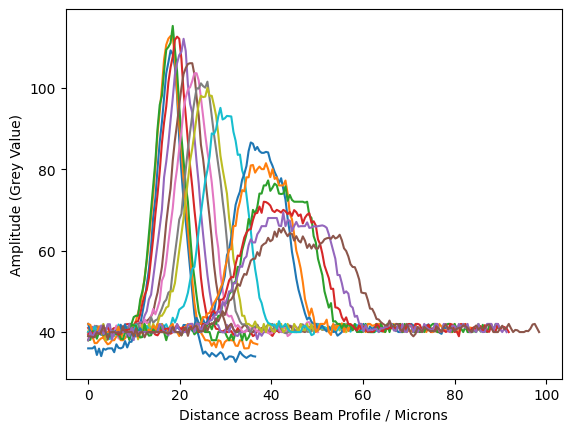

In [26]:
for i in range(len(distances)):
    plt.plot(distances[i], amplitudes[i])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Amplitude (Grey Value)')

plt.show()

## Normalise, cut down data

In [31]:
def data_trim(distances_, amplitudes_, cutoff):

    '''A function to tidy up the raw gaussian data. Implements measures to normalise and trasform data such that
    the only fitting parameter becomes the waist of the beam, W. '''

    new_distances = []
    new_amps = [] # some empty lists to append to at the end of the loop

    for j in range(len(distances_)): # iterate through distances (amps)

        # Get rid of vertical offset - to reduce a fitting parameter
        subt_amp = amplitudes_[j] - np.min(amplitudes_[j])

        # Normalise data by its maximum value
        norm_amp = subt_amp / np.max(subt_amp)

        dist_max = 0 # to add to later

        # # Move data so centred on zero - reduce fitting params further
        # for i in range(norm_amp.size):
        #     if norm_amp[i] == np.max(norm_amp):
        #         dist_max = distances_[j][i]

        # shifted_distances = distances_[j] - dist_max

        shifted_distances = distances_[j]

        cut_dist = 0
        cut_amps = 0

        if len(shifted_distances) > cutoff:
            cut_dist = shifted_distances[0:cutoff]
            cut_amps = norm_amp[0:cutoff]

            # Add adjusted data set to the new large lists
            new_distances.append(cut_dist)
            new_amps.append(cut_amps)

        else:
            new_distances.append(shifted_distances)
            new_amps.append(norm_amp)

    return new_distances, new_amps

In [32]:
all_distances, all_amps = data_trim(distances, amplitudes, 10000000)

Text(0, 0.5, 'Normalised Amplitude')

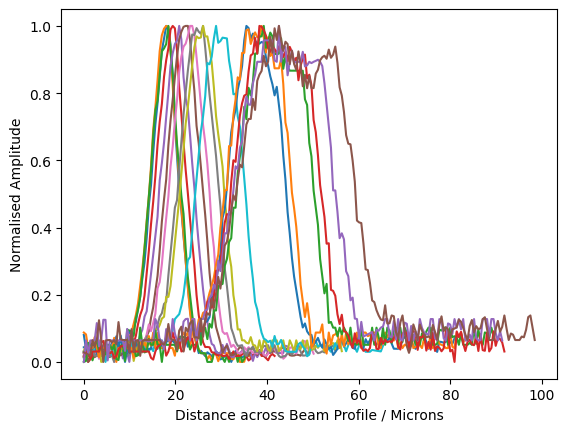

In [33]:
for i in range(len(all_distances)):
    plt.plot(all_distances[i], all_amps[i])

plt.xlabel('Distance across Beam Profile / Microns')
plt.ylabel('Normalised Amplitude')

## Fit Data

Defining useful functions - using chi squared and fit_labs, previously written

In [34]:
def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)

In [36]:
def fit_labs(xdata,ydata, yerrors, function, initial_guess):

    dof = np.size(xdata) - np.size(initial_guess) ## degrees of freedom

    if np.size(yerrors) == 1:

        yerr_extended = np.zeros(np.size(xdata))
        for i in range(np.size(yerr_extended)):
            yerr_extended[i] = yerrors

        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerr_extended, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    if yerrors == 0:

        parameters, covariance = curve_fit(function, xdata, ydata, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    else:
    
        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerrors, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    perrors = np.sqrt(np.diag(covariance))

    chisq_min = chi_squared(parameters,
                        function, 
                        xdata, 
                        ydata, 
                        yerrors) 
    
    chisq_reduced = chisq_min / dof

    # p_value = scipy.stats.chi2.sf(chisq_min, dof)

    yfit = function(xdata, *parameters)

    return yfit, parameters, perrors, chisq_min

In [37]:
def Gauss(x, W, C): ### Defien Gaussian with TWO parameters
    y = np.exp((-2*((x-C)**2) / W**2))
    return y

[ 5.68587017  5.91326446  5.98116729  6.32678715  6.59603256  7.05353089
  7.49591058  7.74916225  8.21237159  9.11569804 10.99728446 12.40383077
 14.29843862 16.48640013 18.96733428 21.83679659]


C:\Users\abiga\AppData\Local\Temp\ipykernel_13628\611882542.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)


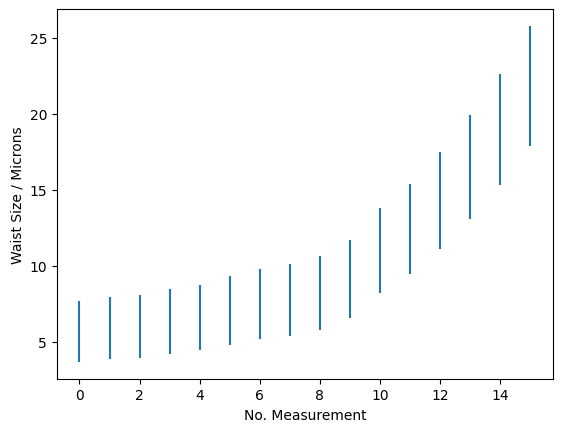

In [41]:
# Create some empty arrays to store values of interest
params_ = np.zeros((len(all_distances),2))
y_fits = [] # NB: this has to be a list due to different sized arrays sitting in it
params_errs_ = np.zeros((len(all_distances),2))
chi_min_array = np.zeros(len(all_distances))

# Populate initial guess array - important to change per data set!!
initial_guesses = np.zeros((len(all_distances),2))
initial_guesses[:,1] = 20
initial_guesses[:,0] = 3
initial_guesses[0,0] = 15
initial_guesses[1,0] = 15
initial_guesses[9:,0] = 40
initial_guesses[9:,1] = 50

for i in range(len(all_distances)):
    singlefit, params_[i], params_errs_[i], chi_min_array[i] = fit_labs(all_distances[i],all_amps[i], 0, Gauss, initial_guesses[i])
    y_fits.append(singlefit)

# Plot waist trend 
plt.errorbar(np.arange(len(distances)),params_[:,0], yerr = params_errs_[:,0], linestyle = '')
plt.xlabel('No. Measurement')
plt.ylabel('Waist Size / Microns')

print(params_[:,0])

## Calculating Z values and Plotting Waist size against Z

In [42]:
# Define Global Path for where 'z' values are stored
z_path = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/1. Data Analysis/Christmas Report/Cleaved-2/Data2/zs.csv'

# Import as dataframe
df_lengths = pd.read_csv(z_path)

# Convert to array. Called 'lengths' as this isnt the z values yet
lengths = np.array(df_lengths['Length'])

In [45]:
print(lengths)

16


This 'lengths' value MIGHT need to be multiplied by cos theta? Where theta is angle of elevation of the fibre... but won't do this yet.

## Fit Waists vs Z

In [ ]:
# Need wavelength of light to calc. Rayleigh Range (in microns)
wavelength = 0.405

In [ ]:
# Define w vs z theoretical relation

def WvsZ(x, min_w, C):
    # define rayleigh range
    RR = (np.pi * min_w**2) / wavelength
    return min_w * np.sqrt(1 + ((x-C)/RR)**2)

Angle of elevation - how to include?

In [ ]:
angle_deg = 9 # from image called 1. ELev_angle
angle = angle_deg * np.pi / 180

waists = waists*np.sin(angle)

In [ ]:
waist_fit, params, params_errs = fit_labs(lengths, waists, 0, WvsZ, np.array([100,-10]))
w0, z0 = params
w0_err, z0_err = params_errs

c:\Users\abiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


[ 3.66105974 84.17462614] [ 0.34452467 19.05353304]


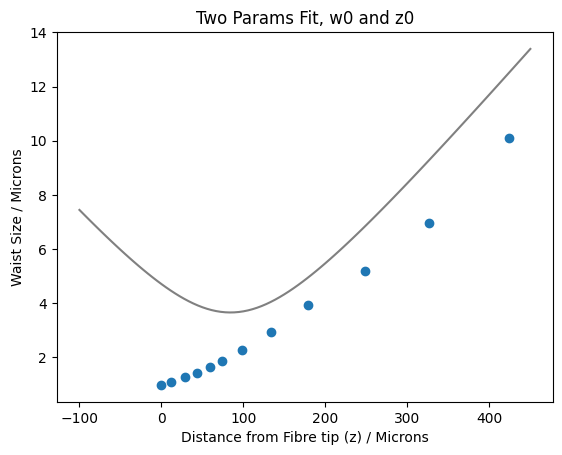

In [ ]:
# Plot waists vs Z:
plt.scatter(lengths,waists)
plt.plot(np.linspace(-100,450,100), WvsZ(np.linspace(-100,450,100), w0, z0), color = 'grey')
plt.xlabel('Distance from Fibre tip (z) / Microns')
plt.ylabel('Waist Size / Microns')
plt.title('Two Params Fit, w0 and z0')

#plt.plot(np.linspace(-100,450,100), WvsZ(np.linspace(-100,450,100), 3, z0), color = 'green')
#plt.scatter(lengths*np.cos(np.pi / 12),waists*np.cos(np.pi / 12), color = 'darkgreen')

print(params, params_errs)

## Try a three parameter fit

In [ ]:
# Define w vs z theoretical relation

def WvsZ3(x, min_w, C,Y):
    # define rayleigh range
    RR = (np.pi * min_w**2) / wavelength
    return min_w * np.sqrt(1 + ((x-C)/RR)**2) + Y # add third parameter for shift in vertical axis

In [ ]:
waist_fit3, params3, params3_errs = fit_labs(lengths, waists, 0, WvsZ3, np.array([3,-10,10]))
w03, z03, Y03 = params3
w03_err, z03_err, Y03_err = params3_errs

[  4.64370109 -31.82845051  -3.67023845] [  0.70786188 102.49547298   1.67656947]


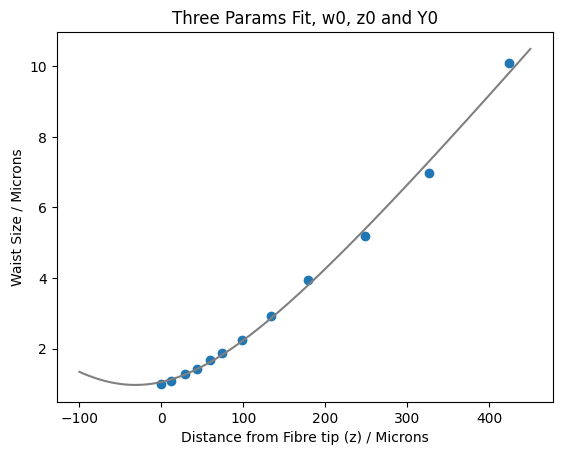

In [ ]:
# Plot waists vs Z:
plt.scatter(lengths,waists)
plt.plot(np.linspace(-100,450,100), WvsZ3(np.linspace(-100,450,100), w03, z03, Y03), color = 'grey')
plt.xlabel('Distance from Fibre tip (z) / Microns')
plt.ylabel('Waist Size / Microns')
plt.title('Three Params Fit, w0, z0 and Y0')

print(params3, params3_errs)

## Comparison to Experiment - Ray Optics Model

In [ ]:
# Defining Parameters of set-up
# info about polarisation maintaining fibre from here:
''' https://www.thorlabs.com/drawings/b4627de8c1f781cd-1251149A-D70E-815D-5BD8491D7FDA5B7B/PM1550-HP-SpecSheet.pdf '''

NA = 0.13 # numerical aperture 
NA_err = 0.01

k0 = 2*np.pi / (wavelength * 10**(-6)) # wavenumber, SI units
a = 8.5e-6 / 2 # core radius, in metres 

#MFR = 10.5e-6 / 2 # mean field radius

In [ ]:
V_no = NA * k0 * a

In [ ]:
print(V_no)

8.571505882016597


Defining the Marcuse Relation below, to compute theoretical minimum waist from V number and core radius

In [ ]:
def marcuse(V,A):
    return A*( 0.65 + 1.619*V**(-3/2) + 2.879*V**(-6) )

In [ ]:
print(marcuse(V_no,a)*10**6)

3.0367198901449814
